# Setup

## Imports

In [1]:
from fastai.structured import *

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
import feather

## Define Useful Features

In [4]:
jtplot_style()

In [5]:
COMPETITION = 'bluebook-for-bulldozers'

In [6]:
DIR_DATA = DIR_KAGGLE / COMPETITION

In [7]:
_rmse = lambda input_, target: ((input_ - target) ** 2).mean()

In [8]:
def _eval(self, x, y):
    return self.score(x, y), _rmse(self.predict(x), y)

RandomForestRegressor.eval = _eval

In [9]:
def split_val(*args, frac):
    assert np.std([len(a) for a in args]) == 0

    n_train = int(len(args[0]) * (1- frac))
    return [a[:n_train] for a in args], [a[n_train:] for a in args]

In [10]:
def _print_scores(model):
    print('Training - r^2, RMSE:', model.eval(x, y))
    print('Validation - r^2, RMSE:', model.eval(x_val, y_val))
    if hasattr(model, 'oob_score_'): print('oob:', model.oob_score_)

In [11]:
def train_model(self):
    self.fit(x, y)
    _print_scores(self)
    return self

In [12]:
RandomForestRegressor.train = train_model

## Load and Preprocess Data

In [13]:
data = feather.read_dataframe(DIR_DATA / 'train.ft')

In [14]:
data.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770   9.159047    1126363     8434         132          18.0      1974   
1  1404019  10.085809    1169900     7110         132          99.0      1986   
2  1415646  10.463103    1262088     3357         132          99.0      1975   
3  1596358   9.852194    1433229     8247         132          99.0      1978   
4  1821514   9.546813    1194089    10150         132          99.0      1980   

   MachineHoursCurrentMeter UsageBand fiModelDesc     ...     saleDay  \
0                       NaN       NaN        TD20     ...          17   
1                       NaN       NaN         416     ...          31   
2                       NaN       NaN         12G     ...          31   
3                       NaN       NaN         644     ...          31   
4                       NaN       NaN         A66     ...          31   

  saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start  \
0             1            17            False              False   
1             1            31             True              False   
2             1            31             True              False   
3             1            31             True              False   
4             1            31             True              False   

  saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start  \
0              False                False           False             False   
1              False                False           False             False   
2              False                False           False             False   
3              False                False           False             False   
4              False                False           False             False   

  saleElapsed  
0   600998400  
1   602208000  
2   602208000  
3   602208000  
4   602208000  

[5 rows x 65 columns]

Drop `SalesID` since it's unique and won't be repeated

In [15]:
to_drop = ['SalesID']

Drop all `fi*` columns since they contain data from the other columns

In [16]:
to_drop += [c for c in data.columns if c[:2] == 'fi']

Drop `ProductGroupDesc` as it's collinear with `ProductGroup`

In [17]:
to_drop.append('ProductGroupDesc')

Drop

In [18]:
data.drop(to_drop, axis=1, inplace=True)

In [19]:
data.head()

SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0   9.159047    1126363     8434         132          18.0      1974   
1  10.085809    1169900     7110         132          99.0      1986   
2  10.463103    1262088     3357         132          99.0      1975   
3   9.852194    1433229     8247         132          99.0      1978   
4   9.546813    1194089    10150         132          99.0      1980   

   MachineHoursCurrentMeter UsageBand ProductSize    state     ...      \
0                       NaN       NaN      Medium    Texas     ...       
1                       NaN       NaN         NaN  Florida     ...       
2                       NaN       NaN         NaN  Florida     ...       
3                       NaN       NaN      Medium  Florida     ...       
4                       NaN       NaN         NaN  Florida     ...       

  saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start  \
0      17             1            17            False              False   
1      31             1            31             True              False   
2      31             1            31             True              False   
3      31             1            31             True              False   
4      31             1            31             True              False   

  saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start  \
0              False                False           False             False   
1              False                False           False             False   
2              False                False           False             False   
3              False                False           False             False   
4              False                False           False             False   

  saleElapsed  
0   600998400  
1   602208000  
2   602208000  
3   602208000  
4   602208000  

[5 rows x 57 columns]

Impute `YearMade == 1000`

In [20]:
data.YearMade.replace(1000, np.NaN, inplace=True)

In [21]:
data.ProductSize.cat.set_categories(['Mini', 'Compact', 'Small', 'Medium',
                                     'Large / Medium', 'Large'], ordered=True, inplace=True)

In [22]:
data.Hydraulics_Flow.cat.set_categories(['None or Unspecified', 'Standard',
                                         'High Flow'], ordered=True, inplace=True)

In [23]:
data.Enclosure.cat.set_categories(['None or Unspecified', 'NO ROPS', 'OROPS', 'EROPS',
                                   'EROPS w AC', 'EROPS AC'], ordered=True, inplace=True)

In [24]:
data.Drive_System.cat.set_categories(['No', 'Two Wheel Drive', 'Four Wheel Drive',
                                      'All Wheel Drive'], ordered=True, inplace=True)

In [25]:
for c in data.Tire_Size.cat.categories:
    r = re.search(r'(\d+)*', c).group()
    if r == '': r = np.NaN
    
    data.Tire_Size.replace(c, float(r), inplace=True)
    
data.Tire_Size = data.Tire_Size.astype(np.float16)

In [26]:
data.Blade_Width.cat.rename_categories({"<12'": "6'"}, inplace=True)
data.Blade_Width.replace("<12'", "6'", inplace=True)

for c in data.Blade_Width.cat.categories:
    r = re.search(r'(\d+)*', c).group()
    if r == '': r = np.NaN
    data.Blade_Width.replace(c, float(r), inplace=True)
    
data.Blade_Width = data.Blade_Width.astype(np.float16)

In [27]:
for c in data.Stick_Length.cat.categories:
    r = re.search(r"^(\d+)' (\d+)\"$", c)
    if r is None: r = np.NaN
    else:
        r = r.groups()
        r = int(r[0]) + int(r[1]) / 12

    data.Stick_Length.replace(c, r, inplace=True)
    
data.Stick_Length = data.Stick_Length.astype(np.float16)

In [28]:
x, y, nas = proc_df(data, 'SalePrice')

In [29]:
(x, y), (x_val, y_val) = split_val(x, y, frac=0.03)

# Feature Importance

## Find Most Important Features

In [30]:
set_rf_samples(50000)

In [31]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()

Training - r^2, RMSE: (0.8912268235951953, 0.05216832115513693)
Validation - r^2, RMSE: (0.8457753426748356, 0.08070144996155325)


In [32]:
fi = rf_feat_importance(model, x)
fi[:10]

cols       imp
7       ProductSize  0.204423
4          YearMade  0.177947
11        Enclosure  0.098255
1           ModelID  0.098127
29   Coupler_System  0.086475
55      saleElapsed  0.052912
31  Hydraulics_Flow  0.036362
0         MachineID  0.029909
43         saleYear  0.020769
30   Grouser_Tracks  0.018923

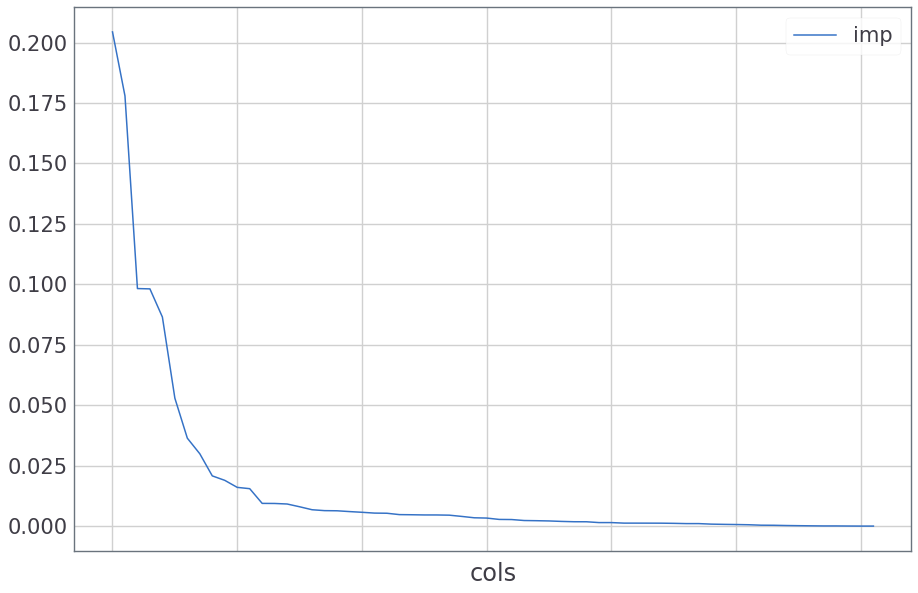

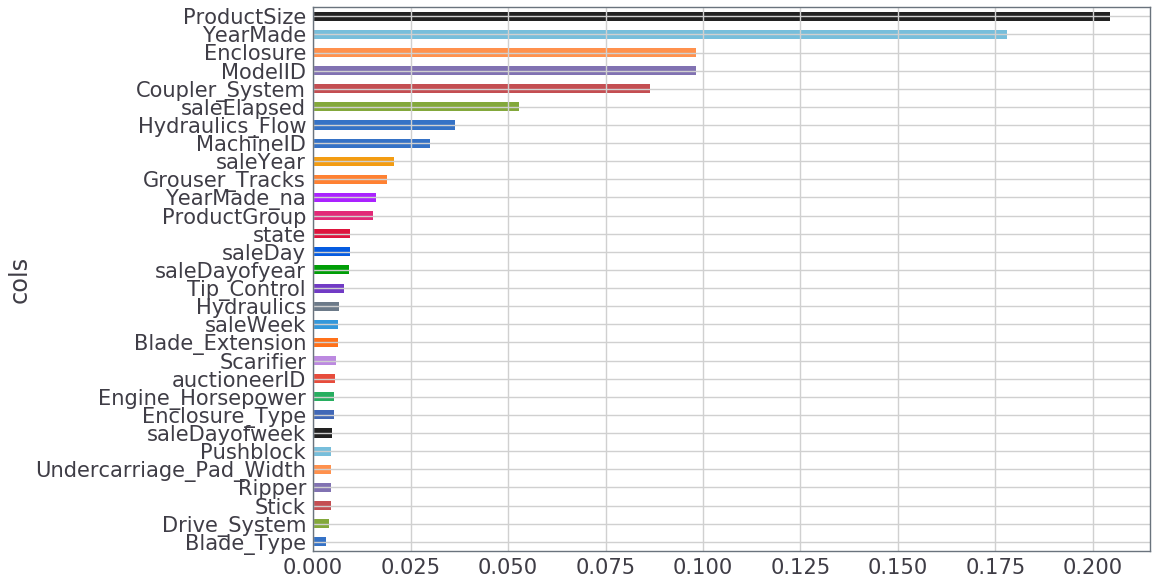

In [33]:
fi.plot('cols', 'imp')
fi[:30][::-1].plot('cols', 'imp', 'barh', legend=False)

## Reduce Features

In [34]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

23

In [35]:
x = x[to_keep]; x_val = x_val[to_keep]

In [36]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()

Training - r^2, RMSE: (0.8882667070865402, 0.05358801223876813)
Validation - r^2, RMSE: (0.8439898008710109, 0.08163577405106516)


In [37]:
fi = rf_feat_importance(model, x)
fi[:10]

cols       imp
0       ProductSize  0.191408
1          YearMade  0.181658
2         Enclosure  0.114923
3           ModelID  0.111566
4    Coupler_System  0.062105
5       saleElapsed  0.054817
6   Hydraulics_Flow  0.041805
7         MachineID  0.032184
11     ProductGroup  0.030608
9    Grouser_Tracks  0.029189

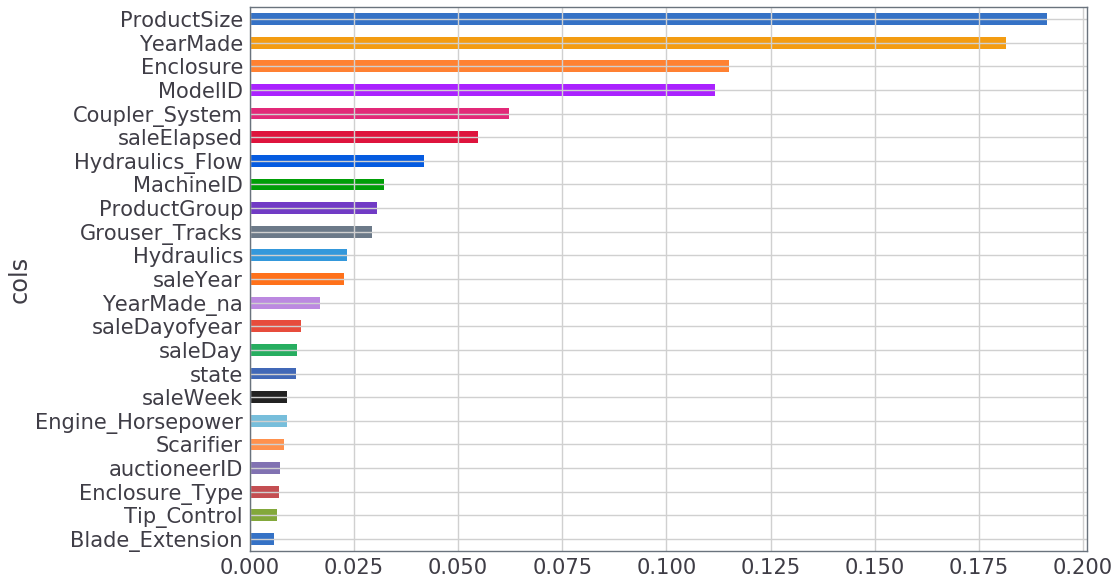

In [38]:
fi[::-1].plot('cols', 'imp', 'barh', legend=False)